# Flow Lenia [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/21_flow_lenia.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [ ]:
import pickle
from importlib import resources

import jax
import jax.numpy as jnp
import mediapy
from flax import nnx

from cax.models.flow_lenia import (
	FlowLenia,
	FreeKernelParams,
	GrowthParams,
	KernelParams,
	RuleParams,
)

## Configuration

In [2]:
seed = 0

spatial_dims = (128, 128)
channel_size = 3

R = 12
T = 10

state_scale = 1

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Model

This section demonstrates how to visualize well-known Lenia creatures by loading rule parameters and patterns from `cax/models/lenia/assets`.

You can run either the VT049W or 5N7KKM section below. You can also experiment with combining rule parameters from one soliton with the pattern of another to observe novel emergent behaviors.

### VT049W

In [3]:
# Load rule params for soliton VT049W
with (
	resources.files("cax.models.lenia.assets.VT049W").joinpath("rule_params.pickle").open("rb") as f
):
	rule_params = pickle.load(f)

In [4]:
# Load pattern for soliton VT049W
with resources.files("cax.models.lenia.assets.VT049W").joinpath("Aquarium.pickle").open("rb") as f:
	pattern = pickle.load(f)

### 5N7KKM

In [5]:
# Load rule params for soliton 5N7KKM
with (
	resources.files("cax.models.lenia.assets.5N7KKM").joinpath("rule_params.pickle").open("rb") as f
):
	rule_params = pickle.load(f)

In [6]:
# Load pattern for soliton 5N7KKM
with (
	resources.files("cax.models.lenia.assets.5N7KKM")
	.joinpath("Aquarium_swarm.pickle")
	.open("rb") as f
):
	pattern = pickle.load(f)

In [7]:
ca = FlowLenia(
	spatial_dims=spatial_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	rule_params=rule_params,
	state_scale=state_scale,
)

## Sample initial state

In [8]:
def sample_state(pattern):
	"""Sample a state with a pattern at the center."""
	# Calculate the center of the state for each dimension
	mid = tuple(dim // 2 for dim in spatial_dims)

	# Scale pattern
	pattern_scaled = pattern
	for axis in range(len(spatial_dims)):
		pattern_scaled = pattern_scaled.repeat(state_scale, axis=axis)

	# Get the shape of the scaled cells
	pattern_spatial_dims = pattern_scaled.shape[:-1]  # Exclude the channel dimension

	# Create empty state with the shape defined by spatial_dims and channel_size
	state = jnp.zeros((*spatial_dims, channel_size))

	# Calculate the slice indices for each dimension
	slices = tuple(slice(m - c // 2, m + c - c // 2) for m, c in zip(mid, pattern_spatial_dims))

	# Place the scaled cells in the center of the state
	state = state.at[slices].set(pattern_scaled)

	return state

## Run

In [ ]:
state_init = sample_state(pattern)
state_final, states = ca(state_init, num_steps=256)

## Visualize


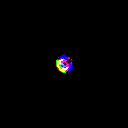

In [12]:
states = jnp.concatenate([state_init[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256, codec="gif")

## Orbium

In [11]:
spatial_dims = (128, 128)
channel_size = 1

R = 12
T = 10

state_scale = 2

### Kernel

In [12]:
kernel_params = KernelParams(
	r=jnp.array(1.0, jnp.float32),
	b=jnp.array([1.0]),
)

### Growth Mapping Function

In [13]:
growth_params = GrowthParams(
	mean=jnp.array(0.15, jnp.float32),
	std=jnp.array(0.015, jnp.float32),
)

### Rule Params

In [14]:
rule_params = RuleParams(
	channel_source=jnp.array(0, jnp.int32),
	channel_target=jnp.array(0, jnp.int32),
	weight=jnp.array(1.0, jnp.float32),
	kernel_params=kernel_params,
	growth_params=growth_params,
)
rule_params = jax.tree.map(lambda x: x[None], rule_params)

### Model

In [15]:
ca = FlowLenia(
	spatial_dims=spatial_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	rule_params=rule_params,
	state_scale=state_scale,
)

### Run

In [16]:
# ruff: noqa: E501
# fmt: off
orbium = jnp.array(
	[
		[
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.14, 0.1, 0.0, 0.0, 0.03, 0.03, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.24, 0.3, 0.3, 0.18, 0.14, 0.15, 0.16, 0.15, 0.09, 0.2, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.15, 0.34, 0.44, 0.46, 0.38, 0.18, 0.14, 0.11, 0.13, 0.19, 0.18, 0.45, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.06, 0.13, 0.39, 0.5, 0.5, 0.37, 0.06, 0.0, 0.0, 0.0, 0.02, 0.16, 0.68, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.11, 0.17, 0.17, 0.33, 0.4, 0.38, 0.28, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18, 0.42, 0.0, 0.0],
		[0.0, 0.0, 0.09, 0.18, 0.13, 0.06, 0.08, 0.26, 0.32, 0.32, 0.27, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.82, 0.0, 0.0],
		[0.27, 0.0, 0.16, 0.12, 0.0, 0.0, 0.0, 0.25, 0.38, 0.44, 0.45, 0.34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.17, 0.0],
		[0.0, 0.07, 0.2, 0.02, 0.0, 0.0, 0.0, 0.31, 0.48, 0.57, 0.6, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49, 0.0],
		[0.0, 0.59, 0.19, 0.0, 0.0, 0.0, 0.0, 0.2, 0.57, 0.69, 0.76, 0.76, 0.49, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0],
		[0.0, 0.58, 0.19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.67, 0.83, 0.9, 0.92, 0.87, 0.12, 0.0, 0.0, 0.0, 0.0, 0.22, 0.07],
		[0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.93, 1.0, 1.0, 1.0, 0.61, 0.0, 0.0, 0.0, 0.0, 0.18, 0.11],
		[0.0, 0.0, 0.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47, 1.0, 1.0, 0.98, 1.0, 0.96, 0.27, 0.0, 0.0, 0.0, 0.19, 0.1],
		[0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 1.0, 0.84, 0.92, 0.97, 0.54, 0.14, 0.04, 0.1, 0.21, 0.05],
		[0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.09, 0.8, 1.0, 0.82, 0.8, 0.85, 0.63, 0.31, 0.18, 0.19, 0.2, 0.01],
		[0.0, 0.0, 0.0, 0.36, 0.1, 0.0, 0.0, 0.0, 0.05, 0.54, 0.86, 0.79, 0.74, 0.72, 0.6, 0.39, 0.28, 0.24, 0.13, 0.0],
		[0.0, 0.0, 0.0, 0.01, 0.3, 0.07, 0.0, 0.0, 0.08, 0.36, 0.64, 0.7, 0.64, 0.6, 0.51, 0.39, 0.29, 0.19, 0.04, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.1, 0.24, 0.14, 0.1, 0.15, 0.29, 0.45, 0.53, 0.52, 0.46, 0.4, 0.31, 0.21, 0.08, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.21, 0.21, 0.22, 0.29, 0.36, 0.39, 0.37, 0.33, 0.26, 0.18, 0.09, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.13, 0.19, 0.22, 0.24, 0.24, 0.23, 0.18, 0.13, 0.05, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.06, 0.08, 0.09, 0.07, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]
		]
	]
).transpose((1, 2, 0))

In [17]:
state_init = sample_state(orbium)
state_final, states = ca(state_init, num_steps=256)

### Visualize

In [21]:
states = jnp.concatenate([state_init[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256)

## Sampling Rules

### Configuration

In [19]:
spatial_dims = (128, 128)
channel_size = 1

R = 20
T = 10

num_rules = 10

state_scale = 1

### Define sampling distribution

In [20]:
def sample_kernel_params(key: jax.Array, k: int = 3):
	"""Sample kernel parameters according to a specific distribution."""
	key_r, key_b, key_a, key_w = jax.random.split(key, 4)
	r = jax.random.uniform(key_r, minval=0.2, maxval=1.0)
	b = jax.random.uniform(key_b, shape=(k,), minval=0.001, maxval=1.0)
	a = jax.random.uniform(key_a, shape=(k,), minval=0.0, maxval=1.0)
	w = jax.random.uniform(key_w, shape=(k,), minval=0.01, maxval=0.5)
	return FreeKernelParams(r=r, b=b, a=a, w=w)


def sample_growth_params(key: jax.Array):
	"""Sample growth parameters according to a specific distribution."""
	key_mean, key_std = jax.random.split(key)
	mean = jax.random.uniform(key_mean, minval=0.05, maxval=0.5)
	std = jax.random.uniform(key_std, minval=0.001, maxval=0.18)
	return GrowthParams(mean=mean, std=std)


def sample_rule_params(key: jax.Array, k: int = 3):
	"""Sample rule parameters according to a specific distribution."""
	key_channel_source, key_channel_target, key_weight, key_kernel_params, key_growth_params = (
		jax.random.split(key, 5)
	)

	# Sample channel source and target
	channel_source = jax.random.randint(key_channel_source, (), minval=0, maxval=channel_size)
	channel_target = jax.random.randint(key_channel_target, (), minval=0, maxval=channel_size)

	# Sample weight
	weight = jax.random.uniform(key_weight, minval=0.01, maxval=1.0)

	# Sample kernel and growth parameters
	kernel_params = sample_kernel_params(key_kernel_params, k)
	growth_params = sample_growth_params(key_growth_params)

	return RuleParams(
		channel_source=channel_source,
		channel_target=channel_target,
		weight=weight,
		kernel_params=kernel_params,
		growth_params=growth_params,
	)

### Sample rules

In [21]:
seed = 0

key = jax.random.key(seed)
keys = jax.random.split(key, num_rules)
rule_params = jax.vmap(sample_rule_params)(keys)

### Instantiate Lenia with sampled rules

In [22]:
ca = FlowLenia(
	spatial_dims=spatial_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	rule_params=rule_params,
	state_scale=state_scale,
)

### Sample initial state

In [24]:
def sample_state(key):
	"""Sample a state with a uniformly sampled random pattern at the center."""
	pattern = jax.random.uniform(key, (40, 40, channel_size))

	# Calculate the center of the state for each dimension
	mid = tuple(dim // 2 for dim in spatial_dims)

	# Scale pattern
	pattern_scaled = pattern
	for axis in range(len(spatial_dims)):
		pattern_scaled = pattern_scaled.repeat(state_scale, axis=axis)

	# Get the shape of the scaled cells
	pattern_spatial_dims = pattern_scaled.shape[:-1]  # Exclude the channel dimension

	# Create empty state with the shape defined by spatial_dims and channel_size
	state = jnp.zeros((*spatial_dims, channel_size))

	# Calculate the slice indices for each dimension
	slices = tuple(slice(m - c // 2, m + c - c // 2) for m, c in zip(mid, pattern_spatial_dims))

	# Place the scaled cells in the center of the state
	state = state.at[slices].set(pattern_scaled)

	return state

### Run

In [25]:
state_init = sample_state(key)
state_final, states = ca(state_init, num_steps=256)

### Visualize


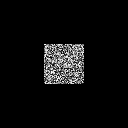

In [ ]:
states = jnp.concatenate([state_init[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256, codec="gif")

## Sampling rules with three channels

### Configuration

In [27]:
spatial_dims = (128, 128)
channel_size = 3

R = 15
T = 10

num_rules = 15

state_scale = 1

### Define sampling distribution

In [28]:
def sample_kernel_params(key: jax.Array, k: int = 3):
	"""Sample kernel parameters according to a specific distribution."""
	key_r, key_b, key_a, key_w = jax.random.split(key, 4)
	r = jax.random.uniform(key_r, minval=0.2, maxval=1.0)
	b = jax.random.uniform(key_b, shape=(k,), minval=0.001, maxval=1.0)
	a = jax.random.uniform(key_a, shape=(k,), minval=0.0, maxval=1.0)
	w = jax.random.uniform(key_w, shape=(k,), minval=0.01, maxval=0.5)
	return FreeKernelParams(r=r, b=b, a=a, w=w)


def sample_growth_params(key: jax.Array):
	"""Sample growth parameters according to a specific distribution."""
	key_mean, key_std = jax.random.split(key)
	mean = jax.random.uniform(key_mean, minval=0.05, maxval=0.5)
	std = jax.random.uniform(key_std, minval=0.001, maxval=0.18)
	return GrowthParams(mean=mean, std=std)


def sample_rule_params(key: jax.Array, k: int = 3):
	"""Sample rule parameters according to a specific distribution."""
	key_channel_source, key_channel_target, key_weight, key_kernel_params, key_growth_params = (
		jax.random.split(key, 5)
	)

	# Sample channel source and target
	channel_source = jax.random.randint(key_channel_source, (), minval=0, maxval=channel_size)
	channel_target = jax.random.randint(key_channel_target, (), minval=0, maxval=channel_size)

	# Sample weight
	weight = jax.random.uniform(key_weight, minval=0.01, maxval=1.0)

	# Sample kernel and growth parameters
	kernel_params = sample_kernel_params(key_kernel_params, k)
	growth_params = sample_growth_params(key_growth_params)

	return RuleParams(
		channel_source=channel_source,
		channel_target=channel_target,
		weight=weight,
		kernel_params=kernel_params,
		growth_params=growth_params,
	)

### Sample rules

In [29]:
seed = 0

key = jax.random.key(seed)
keys = jax.random.split(key, num_rules)
rule_params = jax.vmap(sample_rule_params)(keys)

### Instantiate Lenia with sampled rules

In [30]:
ca = FlowLenia(
	spatial_dims=spatial_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	rule_params=rule_params,
	state_scale=state_scale,
)

### Sample initial state

In [31]:
def sample_state(key):
	"""Sample a state with a uniformly sampled random pattern at the center."""
	pattern = jax.random.uniform(key, (40, 40, channel_size))

	# Calculate the center of the state for each dimension
	mid = tuple(dim // 2 for dim in spatial_dims)

	# Scale pattern
	pattern_scaled = pattern
	for axis in range(len(spatial_dims)):
		pattern_scaled = pattern_scaled.repeat(state_scale, axis=axis)

	# Get the shape of the scaled cells
	pattern_spatial_dims = pattern_scaled.shape[:-1]  # Exclude the channel dimension

	# Create empty state with the shape defined by spatial_dims and channel_size
	state = jnp.zeros((*spatial_dims, channel_size))

	# Calculate the slice indices for each dimension
	slices = tuple(slice(m - c // 2, m + c - c // 2) for m, c in zip(mid, pattern_spatial_dims))

	# Place the scaled cells in the center of the state
	state = state.at[slices].set(pattern_scaled)

	return state

### Run

In [32]:
state_init = sample_state(key)
state_final, states = ca(state_init, num_steps=256)

### Visualize


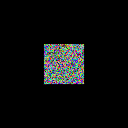

In [44]:
states = jnp.concatenate([state_init[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256, codec="gif")